# Extracting Grism Images with ```pyLINEAR```

This notebook demonstrates how to use pyLINEAR to extract simple grism images, here simple refers to the assumption that there is a single SED for a source. In future notebooks, I will show how this assumption can be addressed on small scales.

The command-line interface (CLI) ```pylinear.py``` can be used to streamline a majority of the operations contained in this notebook. However, this highlights how the steps can be deconstructed and reapplied to meet your individual needs or "pipeline".  Please check the help menu for the CLI: ```prompt> pylinear -h```; I expect many of the variables will be familiar after you have gone through this notebook.


The first few steps will look exactly the same as the simulation notebook.  But when moving to extraction things will get more complex fast.

### Notebook was preparated by Russell Ryan on Aug 2, 2020

In [1]:
# import obligatory things
import pylinear                        # import the pylinear toolkit
from astropy.io import fits            # output products are fits tables
import numpy as np                     # to do some calculations
import os                              # to get file paths
import glob                            # to make collections of files
import matplotlib.pyplot as plt        # to make plots
%matplotlib inline


from astropy.table import Table        # just to make a cool table for the header

info> Loading source catalog
info> Loading an observational catalog
info> Loading sources from CLASSIC segmentation map
     3: 100%|##########| 3/3 [00:00<00:00, 108.26it/s]
info> Loading broadband photometry

info> Loading grism collection
info> Loading observed grism images
info> Loaded 8 images
debug> Figure out if remake works right
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
Default parameters: range = 7500.0,12500.0 A, sampling = 25.0 A
info> updating extraction parameters.
info> Building the matrix: 8 images, 3 sources.
Loading ODTs: 100%|##########| 8/8 [00:01<00:00,  7.46it/s]
info> Compressing the indices
info> Building a damping target
info> Running LSQR with l=4.851869561538457
info> Running LSQR with l=6.1081418857313885
info> Running LSQR with l=7.689695038791591
info> R

In [2]:
# set some values
segfile = 'seg.fits'           # segmentation we already built
obslst  = 'obs.lst'            # name of the obslst
fltlst  = 'flt.lst'            # name of the list of images to extract
beam    = '+1'                 # the beam to simulate
path    = 'tables'             # where the PDTs will be saved
logdamp = [-4,-1,0.1]          # log(damp) values to use (see comments below)
method  = 'grid'               # method to maximize curvature (see comments below)
root    = 'grid'               # the root of the output products
maglim  = 99.0                 # maglim is large number, so use everything

# additional things
seddir  = 'simulated_SEDs'     # used to visualize the results

### Step 1. Load the Sources
This step is the same as for the simulation.

In [3]:
# step 1. Load the sources
sources = pylinear.source.SourceCollection(segfile,obslst,detindex=0,maglim=maglim)

### Step 2. Load the Grism Images

The loading of the images is same as for the simulation.  

But we also need to create a list of the ```flt``` files we wish to extract.  Normally, I do this at the command line with things like ```prompt> \ls *flt.fits > flt.lst```, but we can just do this in python too.

In [4]:
# step 2a. Make a list of images
with open(fltlst,'w') as fp:
    for f in glob.glob('simp*_flt.fits'):    # recall these are the noised images
        print(f,file=fp)

In [5]:
# step 2b. now can load the grism images (in this case will be simulated images)
grisms = pylinear.grism.GrismCollection(fltlst,observed=True)

### Step 3. Make the PDTs

This is the same as for the simulation.

In principle, one can reuse the tables made for the simulation and skip this step altogether.  However, I include it here for completeness to make it a bit clearer when generalizing to observed data.

In [6]:
# step 3a (optional).  the tabulate object
tabulate = pylinear.modules.Tabulate('pdt',path=path,ncpu=0)   # note the ncpu = 0

In [7]:
# step 3b (optional).  run the tabulate module
tabnames = tabulate.run(grisms,sources,beam)

### Step 4. Set the Extraction Ranges

One needs to tell ```pyLINEAR``` the wavelength range and bandwidth, and the ```instruments.xml``` file contains default values.  So there are three options here:
1.  Use the defaults from the ```instruments.xml```  (what is shown here);
2.  Specify these values yourself.  The method ```SourceCollection.update_extraction_parameters()``` takes three mandatory inputs: ```lamb0```, ```lamb1```, ```dlamb```, all in angstroms; or 
3.  Specify these values for each source separately in the segmentation image.  In this case, one needs to use the multi-extension fits files as inputs.  This is not fully implemented yet, so is not discussed.

In [8]:
# step 4. Get extraction ranges (as a tuple) and set them
extraction_parameters = grisms.get_default_extraction()
print('Default parameters: range = {},{} A, sampling = {} A'.format(*extraction_parameters))
sources.update_extraction_parameters(*extraction_parameters)

### Step 5. Run the Extraction Module

The ```pylinear.modules.extract.Extract()``` is the heart-and-soul of the extraction engine.  However, there are (at present) two types of extraction: 1d (*discussed here*) and 2d (an IFU-like fluxcube *discussed in later notebook*).  So we use the method: ```extract1d```, which takes several mandatory inputs.  

- **grisms**: ```GrismCollection```
- **sources**: ```SourceCollection```
- **beam**: string or list of strings indicating beams to extract
- **logdamp**: float or list of floats for the ```method```
- **method**: a string: ```grid```, ```golden```, or ```single```
- **path**: a string to the path where the PDTs are stored

There are several optional arguments.  Look at the code.

In [9]:
# step 5. Do the extractions
pylinear.modules.extract.extract1d(grisms,sources,beam,logdamp,method,root,path,group=False)

### Step 6 (optional).  Inspect the Results

Technically speaking, this is not necessary to extract spectra, but is probably a good idea.  The ```extract1d()``` method will produce two main files: ```ROOT_x1d.fits``` and ```ROOT_lcv.pdf```, which are the spectra and L-curve plot, respectively.  Note: the ```ROOT``` is what we specified above.  

The ```x1d.fits``` file is a MEF fits file of ```BinTable```, each source has its own extension and table, and each group has its own extension and table.  The extensions for source spectra will have ```EXTNAME = 'SOURCE'``` and the ```EXTVER``` keyword will be the ```SEGID```.  Similarly, the extensions for the L-curve data from the groups will have ```EXTNAME = 'GROUP'``` and the ```EXTVER``` will be the ```GRPID```.  The source tables will come first.  ***NOTE: the extracted pyLINEAR spectra are in units of 10^-17 erg/s/cm^2/A***.

The ```lcv.pdf``` is a diagonstic plot of the group tables in the ```x1d.fits```. Each page of the PDF is a different group.  These plots can be reconstructed from the data in the ```x1d.fits``` file.  

In [10]:
# step 6a (optional). Inspect the results
with fits.open('{}_x1d.fits'.format(root)) as hdul:
    hdul.info()

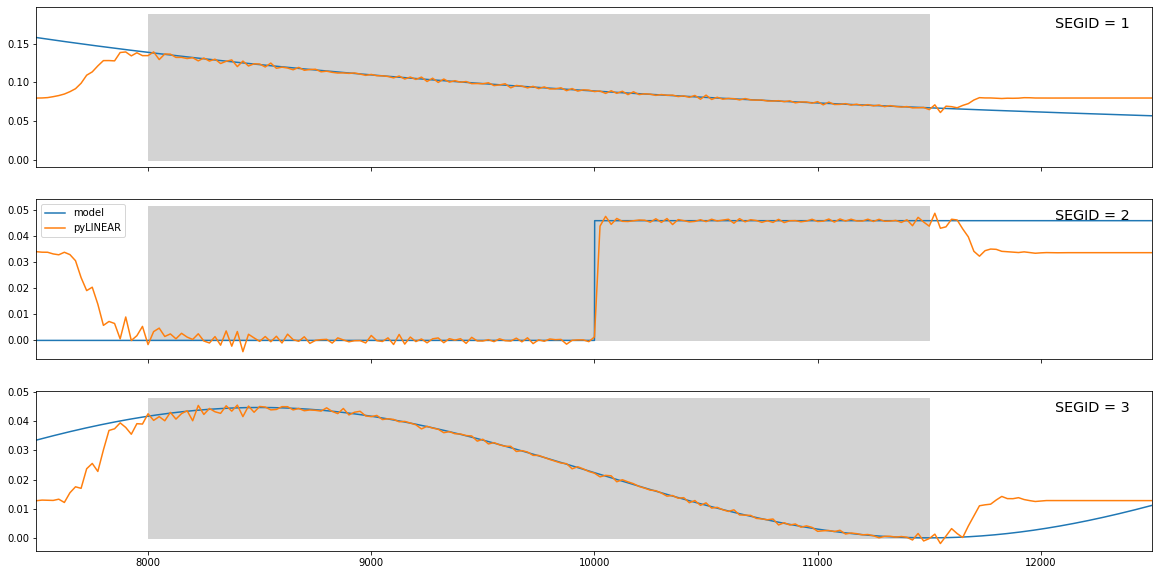

In [11]:
# step 6b (optional). Inspect the Results

# make a plto window
fig,axes = plt.subplots(3,sharex=True,figsize=(20,10))

# the segids we will inspect
segids = [1,2,3]    # ok, we knew this a priori

with fits.open('{}_x1d.fits'.format(root)) as hdul:
    for ax,segid in zip(axes,segids):
        # index the HDUL with a tuple.
        # first value "SOURCE" indicates we want source content (as opposed to
        #             "GROUP" which indicates we want group content)
        # second value is an integer that indicate the segmentation ID
        index = ('SOURCE',segid)
        hdu=hdul[index]

        # read the spectrum that we made from the previous notebook
        lamb,flam = np.loadtxt(os.path.join(seddir,'{}.sed'.format(segid)),usecols=(0,1),unpack=True)
        
        # plot the original spectrum and extracted spectrum, but recall
        # the units that pyLINEAR produces
        ax.plot(lamb,flam/1e-17,label='model')
        ax.plot(hdu.data['wavelength'],hdu.data['flam'],label='pyLINEAR')
        ax.set_xlim(extraction_parameters[0],extraction_parameters[1])
        
        # schematically show the area of good transmission for G102
        ylim = ax.get_ylim()
        ax.fill_between([8000,11500],0,[ylim[1],ylim[1]],color='lightgray')
        
        
        # make a legend for one of the panels
        if segid==2:
            ax.legend()
               
        # put some text on there
        ax.text(0.98,0.85,'SEGID = {}'.format(segid),transform=ax.transAxes,
                verticalalignment='bottom',horizontalalignment='right',
                fontsize='x-large')
        
# NOTE: Things will start to go bad when reach the edge of the sensitivity curve,
#       this is highlighted by the gray region.  Specifically, it will tend toward 

#       the damping target (recall the presentation)

In [12]:
# A helper function to convert a fits header (keyword, value, comment) tuple into
# an astropy.Table.  There might be a better way of doing this?
def header_to_table(hdr):

    keys, values, comments = [],[],[]
    for k in hdr.keys():
        if k not in ('COMMENT','',' '):
            keys.append(k)
            values.append(hdr[k])
            comments.append(hdr.comments[k])
    tab = Table([keys,values,comments],names=['key','value','comments'])
    
    return tab

In [13]:
# step 6c. (optional) view the headers.  There might be useful info in here?
with fits.open('{}_x1d.fits'.format(root)) as hdul:
    # show the primary extension
    tab0 = header_to_table(hdul[0].header)
    tab0.pprint_all()
    
    # show one of the source extensions
    tabs = header_to_table(hdul[('SOURCE',1)].header)
    tabs.pprint_all()
    
    # show one of the group extensions
    tabg = header_to_table(hdul[('GROUP',0)].header)
    tabg.pprint_all()

### Final thoughts

One can tweak many aspects of this extraction to see how the code responds.  Just a few ideas are:
1. disable/enable grouping by setting ```group=False``` or ```group=True``` in the extraction
2. change the inverter method ```inverter='lsmr'```.  LSMR is reportedly more efficient than LSQR, however LSQR came first and is a very well-studied algorithm.  Therefore I made it the default.
3. change the method for maxizing curvature ```method = 'golden'```.  But here, the meaning of ```logdamp``` is different.  

| ```method``` | ```logdamp```                                  |
|--------------|:-----------------------------------------------|
| ```grid```   | 3-element tuple: (start, stop, delta)          |
| ```golden``` | 3-element tuple: (minimum, maximum, tolerance) |
| ```single``` | scalar: single value to compute                |

4. change the default extraction parameters, in particular the ```dlamb```, which is the 3rd element of the tuple ```extraction_parameters```.
5. Use the noiseless images.  You will, of course, get better agreement, but the L-curve results should start to break down.  The code will always creep toward ```logdamp = -np.inf```, which I **THINK** can be implented by ```logdamp=None``` (but use at your own risk).
6. Complicate the previous notebooks and this one by adding more sources, more dithers, more/fewer orients, cranking up the noise, etc.
7. Replicate some of the tests we did:
  - add noise the ```CRVAL```s (to simulate translation errors in astrometry)
  - add unknown flux pedastals to the grism images (to simulate errors in the background subtraction
  - tweak the ```CD``` matrices (to simulate rotation errors in astrometry
  - make extended sources.  large sources will result in broader *effective* line-spread functions (LSFs)
  - the sky is the limit here. 
